#Import

In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
import matplotlib.pyplot as plt #
from sklearn.tree import plot_tree, export_text#
import seaborn as sns #
import pandas as pd #
import numpy as np #
import matplotlib #
import os
import sys #

from sklearn.neighbors import KNeighborsClassifier #
from sklearn.model_selection import GridSearchCV #
from sklearn.model_selection import RandomizedSearchCV#

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import roc_auc_score #
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc

%matplotlib inline

from google.colab import drive #



In [7]:
sys.path.append('/content/drive/MyDrive/Python/ML/Module')

In [8]:
from process_bank_churn import get_processed_data, preprocess_new_data

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


#Format

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

#Functions

In [62]:
def train_auc (model, X_train, X_val, train_targets, val_targets):
    # Навчання моделі
    model.fit(X_train, train_targets)

    y_train_prob = model.predict_proba(X_train)[:, 1]

    train_auc = roc_auc_score(train_targets, y_train_prob)

    return train_auc

def val_auc (model, X_train, X_val, train_targets, val_targets):

    # Навчання моделі
    model.fit(X_train, train_targets)

    y_val_prob = model.predict_proba(X_val)[:, 1]

    val_auc = roc_auc_score(val_targets, y_val_prob)

    return val_auc

def count_auroc(model, X_train, X_val, train_targets, val_targets):
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_val_prob = model.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(train_targets, y_train_prob)
    val_auc = roc_auc_score(val_targets, y_val_prob)
    print(f'Train AUC: {train_auc:.4f}')
    print(f'Validation AUC: {val_auc:.4f}')

    return  train_auc, val_auc


def max_leaf_node_error(ln, X_train, X_val, train_targets, val_targets):
    model = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=ln, random_state=42)
    model.fit(X_train, train_targets)
    train_auc, val_auc = count_auroc(model, X_train, X_val, train_targets, val_targets)
    return {'Maxmax_leaf_nodes': ln, 'Training AUROC': train_auc, 'Validation AUROC': val_auc}



#Завдання

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

##Завдання 0

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [6]:
#зчитування даних
raw_df = pd.read_csv('//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/train.csv.zip')

In [9]:
#препроцесинг даних
X_train, X_val, train_targets, val_targets, model_cols, scaler, encoder, numeric_cols, encoded_cols, categorical_cols = get_processed_data(raw_df)

##Завдання 1

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [50]:
#навчання kNN з параметрами за замовченням
knn = KNeighborsClassifier()

knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [11]:
#точність Knn з допомогою AUROC на тренувальному та валідаційному наборах
count_auroc(knn, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9545
Validation AUC: 0.8662


(0.9545101727305118, 0.8661784072981686)

**Висновки:**
- Модель хороша, бо високе значення AUROC як на тренувальному так і валідаційному наборі
- В той же час модель є перенавченою, бо на валідаційному навборі AUROC на багато нижче ніж на тренувальному наборі

##Завдання 2

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [52]:
#пошук оптимального значення
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 21)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])})

In [53]:
#найкраще значення параметра, найкраща модель
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_)

{'n_neighbors': 7}


In [57]:
knn_best.fit(X_train, train_targets)

KNeighborsClassifier(n_neighbors=7)

In [58]:
#точність Knn_best з допомогою AUROC на тренувальному та валідаційному наборах
count_auroc(knn_best, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9459
Validation AUC: 0.8803


(0.9459452176024682, 0.8803271829343576)

**Висновки:**
- Модель хороша, бо високе значення AUROC як на тренувальному так і валідаційному наборі;
- В той же час модель є перенавченою, бо на валідаційному навборі AUROC на багато нижче ніж на тренувальному наборі;
- порівняно з попереднім пукнтом (2) цього завдання:
  - AUROC knn_best на тренувальному наборі краще (0.9459) ніж на knn (0.9545);
  - AUROC на валідаційному наборі даних краще також на knn_best (0.8803);
  - На knn_best менше рівень перенавченості.
- порівняно з деревом прийняття рішень з попереднього ДЗ:
  - AUROC knn_best на тренувальному наборі краще (0.9459) ніж на дереві рішень (0.9246);
  - AUROC на валідаційному наборі даних краще на деревах рішень (0.9224);
  - Також на деревах рішень менше рівень перенавченості.


##Завдання 3

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

###за параметрами заданими з попереднього HW

In [15]:
#пошук оптимальних параметрів
tree = DecisionTreeClassifier(random_state=42)
params_tree = {
    'max_depth': np.arange(1, 20, 2),
    'max_leaf_nodes': np.arange(2, 10, 1)
}
tree_gs = GridSearchCV(
    tree,
    params_tree,
    scoring='roc_auc',
    verbose=3,
    cv=3)
tree_gs.fit(X_train, train_targets)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.749 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.749 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.749 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=5;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=5;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=5

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc', verbose=3)

In [16]:
#найкращі значення параметра
tree_gs.best_params_

{'max_depth': 5, 'max_leaf_nodes': 9}

In [17]:
#окрема змінна dt_best найкращу модель, знайдену з GridSearchCV
dt_best = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, random_state=42)
dt_best.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, random_state=42)

In [18]:
#оцінка якості моделі dt_best
count_auroc(dt_best, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9003
Validation AUC: 0.8951


(0.9003233245229478, 0.8950967144522944)

###модель з попереднього завдання

In [19]:
#тренування моделі
model_5_1 = DecisionTreeClassifier(max_depth=5, random_state=42)
model_5_1.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [20]:
# пошук leaf nodes з моделі models_5_1
leaf_nodes = model_5_1.tree_.n_leaves
print(f'Number of leaf nodes: {leaf_nodes}')

Number of leaf nodes: 31


In [21]:
#оцінка якості моделі dt_best
count_auroc(model_5_1, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9246
Validation AUC: 0.9224


(0.9245929074083499, 0.9224175183483092)

### автоматичний пошук обох параметрів при розширені діапазону 'max_leaf_nodes': np.arange(2, 31, 1)

In [22]:
tree = DecisionTreeClassifier(random_state=42)
params_tree = {
    'max_depth': np.arange(1, 20, 2),
    'max_leaf_nodes': np.arange(2, 31, 1)
}
tree_gs_1 = GridSearchCV(
    tree,
    params_tree,
    scoring='roc_auc',
    verbose=3,
    cv=3)
tree_gs_1.fit(X_train, train_targets)

Fitting 3 folds for each of 290 candidates, totalling 870 fits
[CV 1/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.749 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.749 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.749 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=5;, score=0.751 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=5;, score=0.735 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             scoring='roc_auc', verbose=3)

In [23]:
#найкращі значення параметра
tree_gs_1.best_params_

{'max_depth': 5, 'max_leaf_nodes': 23}

In [24]:
dt_best_1 = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=23, random_state=42)
dt_best_1.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=23, random_state=42)

In [25]:
#оцінка якості моделі dt_best
count_auroc(dt_best_1, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9217
Validation AUC: 0.9196


(0.9217176001545118, 0.9195857054667671)

###модель за вручну підібраними обома параметрами

Ручний пошук найкращого параметру для max_leaf_nodes для моделі з max_depth=5

In [26]:
errors_df = pd.DataFrame([max_leaf_node_error(ln, X_train, X_val, train_targets, val_targets) for ln in range(2, 32)])

Train AUC: 0.7450
Validation AUC: 0.7337
Train AUC: 0.7579
Validation AUC: 0.7491
Train AUC: 0.8438
Validation AUC: 0.8431
Train AUC: 0.8672
Validation AUC: 0.8660
Train AUC: 0.8893
Validation AUC: 0.8862
Train AUC: 0.8954
Validation AUC: 0.8909
Train AUC: 0.8986
Validation AUC: 0.8937
Train AUC: 0.9003
Validation AUC: 0.8951
Train AUC: 0.9018
Validation AUC: 0.8960
Train AUC: 0.9061
Validation AUC: 0.9025
Train AUC: 0.9101
Validation AUC: 0.9078
Train AUC: 0.9112
Validation AUC: 0.9085
Train AUC: 0.9118
Validation AUC: 0.9092
Train AUC: 0.9124
Validation AUC: 0.9098
Train AUC: 0.9127
Validation AUC: 0.9105
Train AUC: 0.9134
Validation AUC: 0.9107
Train AUC: 0.9149
Validation AUC: 0.9127
Train AUC: 0.9156
Validation AUC: 0.9133
Train AUC: 0.9157
Validation AUC: 0.9134
Train AUC: 0.9212
Validation AUC: 0.9181
Train AUC: 0.9216
Validation AUC: 0.9192
Train AUC: 0.9217
Validation AUC: 0.9196
Train AUC: 0.9221
Validation AUC: 0.9199
Train AUC: 0.9222
Validation AUC: 0.9199
Train AUC: 0.924

In [27]:
errors_df.style.background_gradient(subset='Validation AUROC', cmap='Blues')

,Maxmax_leaf_nodes,Training AUROC,Validation AUROC
0,2,0.745005,0.733747
1,3,0.757899,0.749134
2,4,0.843844,0.843126
3,5,0.867172,0.866031
4,6,0.889262,0.886170
5,7,0.895389,0.890937
6,8,0.898620,0.893736
7,9,0.900323,0.895097
8,10,0.901830,0.895964
9,11,0.906137,0.902522


**Висновки проміжні:**
Найкращий показник max_leaf_nodes=26

In [28]:
#тренування моделі
model_5 = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=26, random_state=42)
model_5.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=26, random_state=42)

In [29]:
#оцінка якості моделі dt_best
count_auroc(model_5, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9244
Validation AUC: 0.9222


(0.924363629165889, 0.9221675012003567)

### зведені дані

In [66]:
# Створення списку словників
data = [
    {'Model': dt_best, 'Coment': 'за параметрами заданими в завданні', 'Max_depth': 5, 'Max_leaf_nodes': 9 },
    {'Model': model_5_1, 'Coment': 'модель  з попереднього HW', 'Max_depth': 5, 'Max_leaf_nodes': 31 },
    {'Model': dt_best_1, 'Coment': "автопошук обох параметрів при розширені діапазону 'max_leaf_nodes': np.arange(2, 31, 1)", 'Max_depth': 5, 'Max_leaf_nodes': 23 },
    {'Model': model_5, 'Coment': 'модель за вручну підібраними обома параметрами', 'Max_depth': 5, 'Max_leaf_nodes': 26}
]

# Створення DataFrame
df = pd.DataFrame(data)


In [67]:
#розрахунок для тренувального набору AUROC
df['AUROC_train'] = df['Model'].apply(lambda model: train_auc(model, X_train, X_val, train_targets, val_targets))

In [68]:
#розрахунок для валідаційного набору AUROC
df['AUROC_val'] = df['Model'].apply(lambda model: val_auc(model, X_train, X_val, train_targets, val_targets))

In [69]:
df.head()

,Model,Coment,Max_depth,Max_leaf_nodes,AUROC_train,AUROC_val
0,"DecisionTreeClassifier(max_depth=5, max_leaf_n...",за параметрами заданими в завданні,5,9,0.900323,0.895097
1,"DecisionTreeClassifier(max_depth=5, random_sta...",модель з попереднього HW,5,31,0.924593,0.922418
2,"DecisionTreeClassifier(max_depth=5, max_leaf_n...",автопошук обох параметрів при розширені діапаз...,5,23,0.921718,0.919586
3,"DecisionTreeClassifier(max_depth=5, max_leaf_n...",модель за вручну підібраними обома параметрами,5,26,0.924364,0.922168


**Висновки:**
У всіх млоделей високий показник якості.
Якщо не зважати на ресурси, то найкраще себе показала модель з max_deph=5 та max_leaf_nodes=31.
З точки зопу ресурсів висока якість моделі з max_deph=5 та max_leaf_nodes=9.


##Завдання 4

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [34]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [35]:
model = DecisionTreeClassifier(random_state=42)

In [36]:
search = RandomizedSearchCV(
    model,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    refit=True
)

In [37]:
%%time
search.fit(X_train, train_targets)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, max_features=None, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, max_features=None, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, max_features=None, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END crite

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc', verbose=2)

In [38]:
display(search.best_estimator_, search.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=15,
                       min_samples_leaf=8, min_samples_split=5,
                       random_state=42)

0.9127109261290052

##Завдання 5

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

###Prunning

In [217]:
tree_prun = DecisionTreeClassifier(max_depth=5, random_state=42)
path = tree_prun.cost_complexity_pruning_path(X_train, train_targets)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

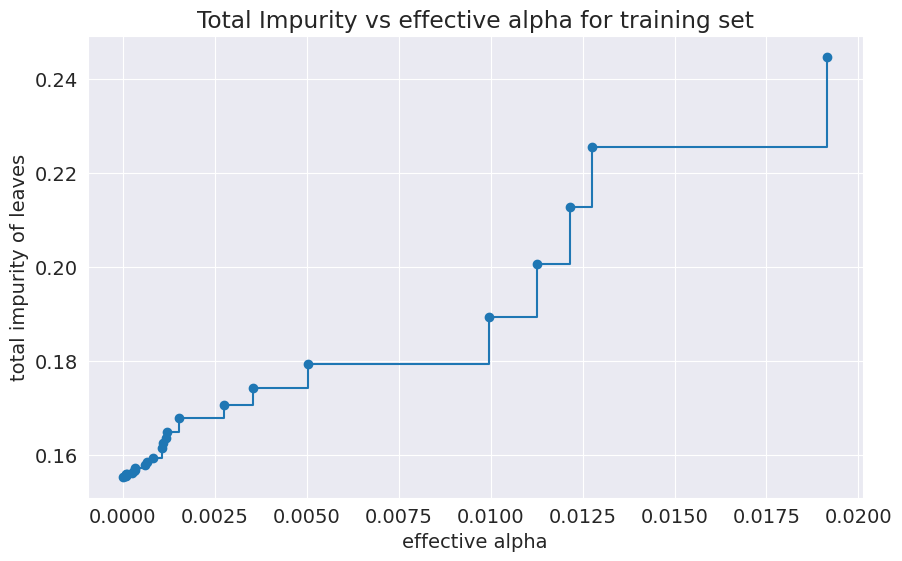

In [218]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

In [219]:
tree_pruns = []
for ccp_alpha in ccp_alphas[-10:]:
    tree_prun = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree_prun.fit(X_train, train_targets)
    tree_pruns.append(tree_prun)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        tree_pruns[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 3 with ccp_alpha: 0.07952674593174541


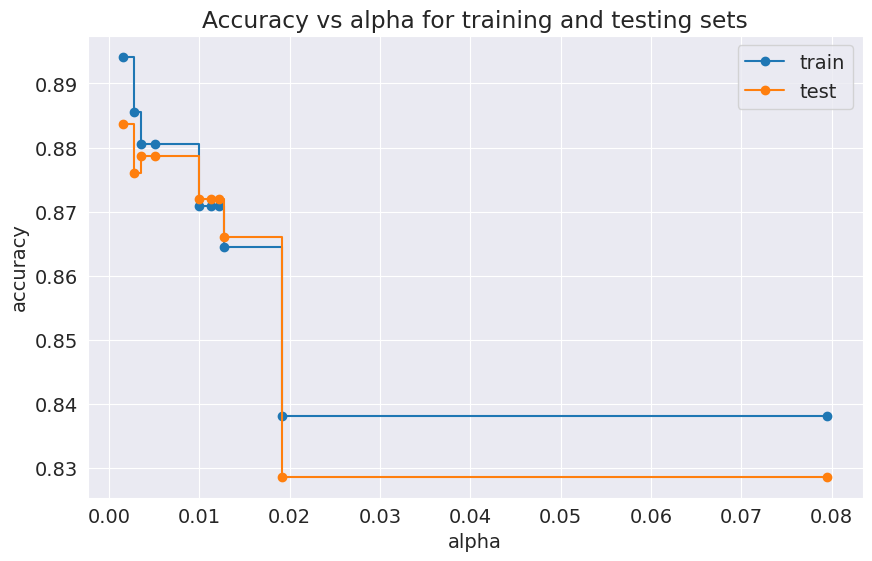

In [220]:
train_scores = [tree_prun.score(X_train, train_targets) for tree_prun in tree_pruns]
val_scores = [tree_prun.score(X_val, val_targets) for tree_prun in tree_pruns]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[-10:], train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[-10:], val_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [237]:
tree_prun = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[-18])
tree_prun.fit(X_train, train_targets)

DecisionTreeClassifier(ccp_alpha=0.00033508830396877104, random_state=42)

In [239]:
tree_prun.tree_.max_depth

8

In [240]:
# пошук leaf nodes з моделі models_5_1
leaf_nodes = tree_prun.tree_.n_leaves
print(f'Number of leaf nodes: {leaf_nodes}')

Number of leaf nodes: 41


In [238]:
count_auroc(tree_prun, X_train, X_val, train_targets, val_targets)

Train AUC: 0.9293
Validation AUC: 0.9241


(0.92927694858015, 0.9240733246450374)

###Зведення метрик по моделях

In [241]:
# Створення списку словників
data_1 = [
    {'Model': dt_best, 'Coment': 'за параметрами заданими в завданні', 'Max_depth': 5, 'Max_leaf_nodes': 9 },
    {'Model': model_5_1, 'Coment': 'модель  з попереднього HW', 'Max_depth': 5, 'Max_leaf_nodes': 31 },
    {'Model': dt_best_1, 'Coment': "автопошук обох параметрів при розширені діапазону 'max_leaf_nodes': np.arange(2, 31, 1)", 'Max_depth': 5, 'Max_leaf_nodes': 23 },
    {'Model': model_5, 'Coment': 'модель за вручну підібраними обома параметрами', 'Max_depth': 5, 'Max_leaf_nodes': 26},
    {'Model': knn, 'Coment': ' kNN з параметрами за замовченням', 'Max_depth': 0, 'Max_leaf_nodes': 0},
    {'Model': knn_best, 'Coment': 'kNN з n_neighbors=7 ', 'Max_depth': 0, 'Max_leaf_nodes':0},
    {'Model': tree_prun, 'Coment': 'дерево рішень з prunning ', 'Max_depth': 8, 'Max_leaf_nodes':41}
]

# Створення DataFrame
df_1 = pd.DataFrame(data_1)

In [242]:
#розрахунок для тренувального набору AUROC
df_1['AUROC_train'] = df_1['Model'].apply(lambda model: train_auc(model, X_train, X_val, train_targets, val_targets))

In [243]:
#розрахунок для валідаційного набору AUROC
df_1['AUROC_val'] = df_1['Model'].apply(lambda model: val_auc(model, X_train, X_val, train_targets, val_targets))

In [244]:
df_1.head(7)

,Model,Coment,Max_depth,Max_leaf_nodes,AUROC_train,AUROC_val
0,"DecisionTreeClassifier(max_depth=5, max_leaf_n...",за параметрами заданими в завданні,5,9,0.900323,0.895097
1,"DecisionTreeClassifier(max_depth=5, random_sta...",модель з попереднього HW,5,31,0.924593,0.922418
2,"DecisionTreeClassifier(max_depth=5, max_leaf_n...",автопошук обох параметрів при розширені діапаз...,5,23,0.921718,0.919586
3,"DecisionTreeClassifier(max_depth=5, max_leaf_n...",модель за вручну підібраними обома параметрами,5,26,0.924364,0.922168
4,KNeighborsClassifier(),kNN з параметрами за замовченням,0,0,0.954510,0.866178
5,KNeighborsClassifier(n_neighbors=7),kNN з n_neighbors=7,0,0,0.945945,0.880327
6,DecisionTreeClassifier(ccp_alpha=0.00033508830...,дерево рішень з prunning,8,41,0.929277,0.924073


###Submission

In [253]:
#завантаження тестових даних
test_raw_df = pd.read_csv('//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/test.csv')

In [254]:
#попередня обробка тестових даних
X_test = preprocess_new_data(test_raw_df, scaler, encoder, numeric_cols, categorical_cols, encoded_cols, model_cols)

In [255]:
#передбачення на тестових даних
test_raw_df['Exited'] = dt_best.predict_proba(X_test)[:,1]

In [256]:
ss = pd.read_csv('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/sample_submission.csv')

In [257]:
ss['Exited'] = ss['id'].map(test_raw_df.set_index('id')['Exited'])

In [259]:
ss.to_csv('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/submission_tree_best.csv', index=False)

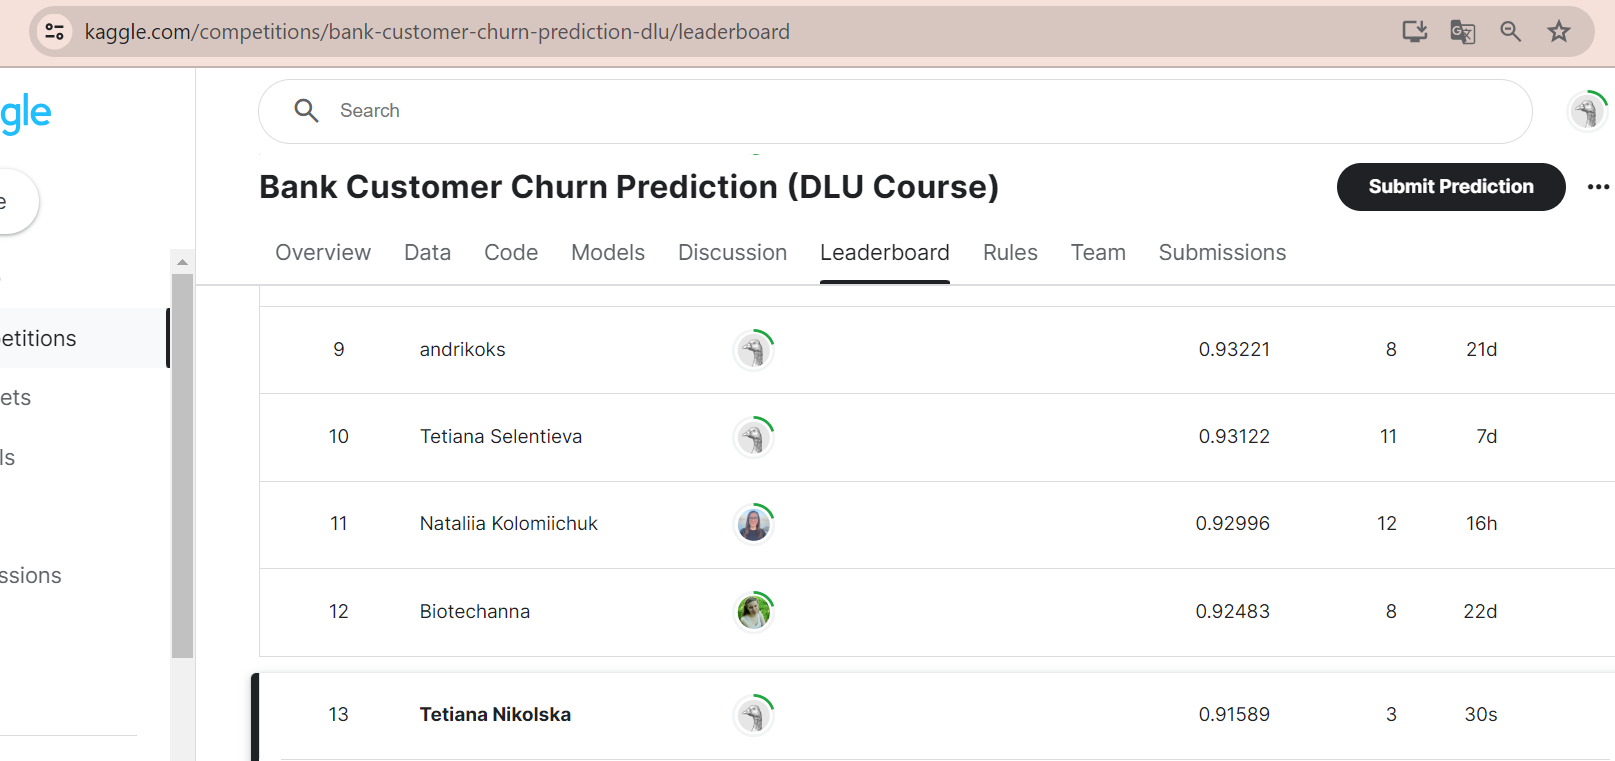

**Висновки:**
Найкращий скор по валідаційному набору у моделі DecisionTreeClassifier(ccp_alpha=0.00033508830...)